### Model_gd

#### linear

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# import torch.utils.data
import math
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim     # for constructing optimizer
from typing import Optional
import time
from kernels.quantize_gemm_int8 import *

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 卷积层
        # input:(batch_size, 1, 6, 6), output:(batch_size, num_kernels, 3, 3)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4096, kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=4096),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=1),
        )
        
        # 全连接层
        self.fc = nn.Sequential(
            nn.Linear(in_features=4096*3*3, out_features=8192),
            nn.ReLU(),
            nn.Linear(in_features=8192, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=2048, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=1),
        )
        
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, x):
        x = self.conv(x)
        # x = x.view(x.shape[0], -1)  # (batch_size, 4096*3*3)
        B = x.shape[0]
        Cin = x.shape[1] * x.shape[2] * x.shape[3]  # 计算出 Cin = 4096 * 3 * 3
        T = 1  # 设置 T = 1，因为不涉及序列长度，这里作为占位符
        x = x.view(B, T, Cin)
        x = self.fc(x)
        x = x.view(x.shape[0], -1)    # (batch_size, 1)
        x = self.sigmoid(x)     
        return x
    
class TritonLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True, device=None, dtype=None):
        super().__init__()
        factory_kwargs = {'device': device, 'dtype': dtype}
        self.in_features = in_features
        self.out_features = out_features
        
        # 初始化权重 (out_features, in_features)
        self.weight = nn.Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        
        if bias:
            self.bias = nn.Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        
        # 预计算量化权重
        self.register_buffer('quantized_weight', None)
        self.register_buffer('weight_scale', None)
        
        self.reset_parameters()
        self.quantize_weight()  # 初始化时预量化权重
    
    def reset_parameters(self):
        # 标准的 PyTorch 初始化方法
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            nn.init.uniform_(self.bias, -bound, bound)
    
    def quantize_weight(self):
        # 转置权重以匹配 matmul 需求：从 (out_features, in_features) 到 (in_features, out_features)
        weight_t = self.weight.t().contiguous()
        # 按列量化（相当于原始权重的行）
        quantized_weight, weight_scale = quantize_int8(weight_t, axis=0)
        self.quantized_weight = quantized_weight
        self.weight_scale = weight_scale
    
    def forward(self, input):
        # 如果处于训练模式或权重尚未量化，则量化权重
        if self.training or self.quantized_weight is None:
            self.quantize_weight()
        
        # 处理输入
        original_shape = input.shape
        if input.dim() > 2:
            # 将高维输入重塑为 2D
            input = input.reshape(-1, input.size(-1))
        
        # 量化输入
        quantized_input, input_scale = quantize_int8_perrow(input)
        
        # 执行量化矩阵乘法
        output = matmul_int8(quantized_input, input_scale, 
                           self.quantized_weight, self.weight_scale)
        
        # 添加偏置（如果存在）
        if self.bias is not None:
            output = output + self.bias
        
        # 恢复原始维度（如果需要）
        if len(original_shape) > 2:
            output_shape = original_shape[:-1] + (self.out_features,)
            output = output.reshape(output_shape)
        
        return output
    
    
class NetWithTriton(nn.Module):
    def __init__(self):
        super(NetWithTriton, self).__init__()
        # 卷积层保持不变
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4096, kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=4096),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=1),
        )
        
        # 全连接层替换为TritonLinear
        self.fc = nn.Sequential(
            TritonLinear(in_features=4096*3*3, out_features=8192),
            nn.ReLU(),
            TritonLinear(in_features=8192, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            TritonLinear(in_features=4096, out_features=2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            TritonLinear(in_features=2048, out_features=1024),
            nn.ReLU(),
            TritonLinear(in_features=1024, out_features=256),
            nn.ReLU(),
            TritonLinear(in_features=256, out_features=1),
        )
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.conv(x)
        B = x.shape[0]
        Cin = x.shape[1] * x.shape[2] * x.shape[3]  # 计算出 Cin = 4096 * 3 * 3
        T = 1  # 设置 T = 1，因为不涉及序列长度，这里作为占位符
        x = x.view(B, T, Cin)
        x = self.fc(x)
        x = x.view(x.shape[0], -1)    # (batch_size, 1)
        x = self.sigmoid(x)     
        return x
    
def convert_pytorch_to_triton_model(pytorch_model):
    """
    将标准 PyTorch 模型转换为使用 TritonLinear 的模型
    """
    triton_model = NetWithTriton()
    
    # 复制卷积层权重
    triton_model.conv.load_state_dict(pytorch_model.conv.state_dict())
    
    # 直接按顺序匹配Linear层
    pytorch_linears = [m for m in pytorch_model.fc if isinstance(m, nn.Linear)]
    triton_linears = [m for m in triton_model.fc if isinstance(m, TritonLinear)]
    
    # 确保两者有相同数量的Linear层
    assert len(pytorch_linears) == len(triton_linears), "PyTorch和Triton模型的Linear层数量不匹配"
    
    # 逐一复制权重
    for pytorch_linear, triton_linear in zip(pytorch_linears, triton_linears):
        # 打印出形状以便调试
        print(f"复制权重: PyTorch {pytorch_linear.weight.shape} -> Triton {triton_linear.weight.shape}")
        
        # 确保形状匹配
        assert pytorch_linear.weight.shape == triton_linear.weight.shape, \
            f"权重形状不匹配: PyTorch {pytorch_linear.weight.shape} vs Triton {triton_linear.weight.shape}"
        
        # 复制权重和偏置
        triton_linear.weight.data.copy_(pytorch_linear.weight.data)
        if pytorch_linear.bias is not None and triton_linear.bias is not None:
            triton_linear.bias.data.copy_(pytorch_linear.bias.data)
        
        # 更新量化权重
        triton_linear.quantize_weight()
    
    return triton_model

def run_inference(batch_sizes=[64, 128, 256, 512], num_batches=5):
    """
    运行多批次推理并比较 PyTorch 和 Triton 模型性能
    """
    print("开始推理测试...")
    
    # 定义设备
    device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
    torch.cuda.set_device(device)  # 确保默认设备是device
    torch.cuda.empty_cache()  # 清空未使用的 GPU 内存
    
    # 尝试加载预训练模型
    try:
        model_state_dict = torch.load("model.pt")
        print("成功加载预训练模型权重")
        pytorch_model = Net()
        pytorch_model.load_state_dict(model_state_dict)
    except:
        print("无法加载预训练模型，使用默认初始化权重")
        pytorch_model = Net()
    
    # 将模型转为使用 Triton 实现的版本
    pytorch_model = pytorch_model.to(device).half()
    triton_model = convert_pytorch_to_triton_model(pytorch_model)
    triton_model = triton_model.to(device).half()
    
    # 设置为评估模式
    pytorch_model.eval()
    triton_model.eval()
    
    # 针对不同批次大小进行测试
    for batch_size in batch_sizes:
        print(f"\n==== 批次大小: {batch_size} ====")
        
        # 准备随机输入数据
        inputs = torch.randn(batch_size, 1, 6, 6, device=device, dtype=torch.float16)
        
        # 预热
        for _ in range(10):
            with torch.no_grad():
                _ = pytorch_model(inputs)
                _ = triton_model(inputs)
        torch.cuda.synchronize()
        
        # PyTorch 模型推理
        pytorch_times = []
        for i in range(num_batches):
            torch.cuda.synchronize()
            start_time = time.time()
            with torch.no_grad():
                pytorch_output = pytorch_model(inputs)
            torch.cuda.synchronize()
            end_time = time.time()
            pytorch_times.append(end_time - start_time)
        
        # Triton 模型推理
        triton_times = []
        for i in range(num_batches):
            torch.cuda.synchronize()
            start_time = time.time()
            with torch.no_grad():
                triton_output = triton_model(inputs)
            torch.cuda.synchronize()
            end_time = time.time()
            triton_times.append(end_time - start_time)
        
        # 计算性能指标
        avg_pytorch_time = sum(pytorch_times) / len(pytorch_times)
        avg_triton_time = sum(triton_times) / len(triton_times)
        speedup = avg_pytorch_time / avg_triton_time if avg_triton_time > 0 else float('inf')
        
        # 验证输出是否接近
        output_diff = torch.abs(pytorch_output - triton_output).mean().item()
        
        # 打印结果
        print(f"PyTorch 平均推理时间: {avg_pytorch_time*1000:.2f} ms")
        print(f"Triton  平均推理时间: {avg_triton_time*1000:.2f} ms")
        print(f"加速比: {speedup:.2f}x")
        print(f"输出差异 (平均绝对误差): {output_diff:.6f}")
        
        # 打印一些样本输出
        print("\n样本输出比较 (前5个):")
        if batch_size >= 5:
            for i in range(5):
                print(f"  样本 {i}: PyTorch={pytorch_output[i].item():.4f}, Triton={triton_output[i].item():.4f}")
        else:
            for i in range(batch_size):
                print(f"  样本 {i}: PyTorch={pytorch_output[i].item():.4f}, Triton={triton_output[i].item():.4f}")


In [2]:
run_inference(batch_sizes=[256, 512, 1024], num_batches=5)

开始推理测试...


/tmp/ipykernel_2790889/316016411.py:215: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load("model.pt")


无法加载预训练模型，使用默认初始化权重
复制权重: PyTorch torch.Size([8192, 36864]) -> Triton torch.Size([8192, 36864])
复制权重: PyTorch torch.Size([4096, 8192]) -> Triton torch.Size([4096, 8192])
复制权重: PyTorch torch.Size([2048, 4096]) -> Triton torch.Size([2048, 4096])
复制权重: PyTorch torch.Size([1024, 2048]) -> Triton torch.Size([1024, 2048])
复制权重: PyTorch torch.Size([256, 1024]) -> Triton torch.Size([256, 1024])
复制权重: PyTorch torch.Size([1, 256]) -> Triton torch.Size([1, 256])

==== 批次大小: 256 ====
PyTorch 平均推理时间: 1.56 ms
Triton  平均推理时间: 1.31 ms
加速比: 1.19x
输出差异 (平均绝对误差): 0.000097

样本输出比较 (前5个):
  样本 0: PyTorch=0.4995, Triton=0.4995
  样本 1: PyTorch=0.4998, Triton=0.4995
  样本 2: PyTorch=0.4988, Triton=0.4988
  样本 3: PyTorch=0.4990, Triton=0.4990
  样本 4: PyTorch=0.4988, Triton=0.4988

==== 批次大小: 512 ====
PyTorch 平均推理时间: 3.18 ms
Triton  平均推理时间: 1.97 ms
加速比: 1.62x
输出差异 (平均绝对误差): 0.000090

样本输出比较 (前5个):
  样本 0: PyTorch=0.4985, Triton=0.4985
  样本 1: PyTorch=0.4990, Triton=0.4990
  样本 2: PyTorch=0.4995, Triton=0.4995
  

#### conv2d+linear

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# import torch.utils.data
import math
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim     # for constructing optimizer
from typing import Optional
import time
from kernels.quantize_gemm_int8 import *
from kernels.conv2d import conv2d_triton

class GDdataset(Dataset):
    def __init__(self, path):
        self.data = pd.read_csv(path)
        SFR = torch.tensor(self.data.iloc[:, 2:46].values)
        blocks = [SFR[:, i:i+4].reshape(-1, 2, 2) for i in range(0, 45, 5)] # 将36列中的每4列合并成一个2*2矩阵，得到9个块
        
        self.value = torch.cat([torch.cat(blocks[i:i+3], dim=2) for i in range(0, 9, 3)], dim=1) # 将9个块按3*3的方式拼成一个大矩阵
        self.value = self.value.unsqueeze(1).to(torch.float32)
        
        self.target = torch.tensor([1.0 if x == 'OK' else 0.0 for x in self.data.iloc[:, 48].values])
        self.target = self.target.unsqueeze(1)
        
    def __getitem__(self, index):
        return self.value[index], self.target[index]
        
        
    def __len__(self):
        return len(self.data)
    


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 卷积层
        # input:(batch_size, 1, 6, 6), output:(batch_size, num_kernels, 3, 3)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4096, kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=4096),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=1),
        )
        
        # 全连接层
        self.fc = nn.Sequential(
            nn.Linear(in_features=4096*3*3, out_features=8192),
            nn.ReLU(),
            nn.Linear(in_features=8192, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=2048, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=1),
        )
        
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, x):
        x = self.conv(x)
        # x = x.view(x.shape[0], -1)  # (batch_size, 4096*3*3)
        B = x.shape[0]
        Cin = x.shape[1] * x.shape[2] * x.shape[3]  # 计算出 Cin = 4096 * 3 * 3
        T = 1  # 设置 T = 1，因为不涉及序列长度，这里作为占位符
        x = x.view(B, T, Cin)
        x = self.fc(x)
        x = x.view(x.shape[0], -1)    # (batch_size, 1)
        x = self.sigmoid(x)     
        return x
    
class TritonLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True, device=None, dtype=None):
        super().__init__()
        factory_kwargs = {'device': device, 'dtype': dtype}
        self.in_features = in_features
        self.out_features = out_features
        
        # 初始化权重 (out_features, in_features)
        self.weight = nn.Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        
        if bias:
            self.bias = nn.Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        
        # 预计算量化权重
        self.register_buffer('quantized_weight', None)
        self.register_buffer('weight_scale', None)
        
        self.reset_parameters()
        self.quantize_weight()  # 初始化时预量化权重
    
    def reset_parameters(self):
        # 标准的 PyTorch 初始化方法
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            nn.init.uniform_(self.bias, -bound, bound)
    
    def quantize_weight(self):
        # 转置权重以匹配 matmul 需求：从 (out_features, in_features) 到 (in_features, out_features)
        weight_t = self.weight.t().contiguous()
        # 按列量化（相当于原始权重的行）
        quantized_weight, weight_scale = quantize_int8(weight_t, axis=0)
        self.quantized_weight = quantized_weight
        self.weight_scale = weight_scale
    
    def forward(self, input):
        # 如果处于训练模式或权重尚未量化，则量化权重
        if self.training or self.quantized_weight is None:
            self.quantize_weight()
        
        # 处理输入
        original_shape = input.shape
        if input.dim() > 2:
            # 将高维输入重塑为 2D
            input = input.reshape(-1, input.size(-1))
        
        # 量化输入
        quantized_input, input_scale = quantize_int8_perrow(input)
        
        # 执行量化矩阵乘法
        output = matmul_int8(quantized_input, input_scale, 
                           self.quantized_weight, self.weight_scale)
        
        # 添加偏置（如果存在）
        if self.bias is not None:
            output = output + self.bias
        
        # 恢复原始维度（如果需要）
        if len(original_shape) > 2:
            output_shape = original_shape[:-1] + (self.out_features,)
            output = output.reshape(output_shape)
        
        return output

class Conv2dTriton(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True, device=None, dtype=None):
        super(Conv2dTriton, self).__init__()
        
        # Handle kernel_size as int or tuple
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        
        # Currently, the Triton implementation only supports stride = kernel_size
        if isinstance(stride, int):
            stride = (stride, stride)
        
        assert stride == kernel_size, "The Triton implementation only supports stride == kernel_size"
        assert padding == 0, "The Triton implementation doesn't support padding"
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        
        # Initialize weights and bias
        self.weight = nn.Parameter(torch.empty((out_channels, in_channels, kernel_size[0], kernel_size[1])))
        if bias:
            self.bias = nn.Parameter(torch.empty(out_channels))
        else:
            self.register_parameter('bias', None)
            
        self.reset_parameters()
        
    def reset_parameters(self):
        # Standard initialization as in PyTorch
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            nn.init.uniform_(self.bias, -bound, bound)
    
    def forward(self, x):
        # Ensure input dimensions are divisible by kernel dimensions
        batch_size, channels, height, width = x.shape
        assert height % self.kernel_size[0] == 0 and width % self.kernel_size[1] == 0, \
            f"Input height ({height}) and width ({width}) should be divisible by kernel dimensions ({self.kernel_size})"
        
        # Use the Triton implementation
        bias_tensor = self.bias if self.bias is not None else torch.zeros(self.out_channels, device=x.device, dtype=x.dtype)
        output = conv2d_triton(x, self.weight, bias_tensor)
        
        # Ensure output has the same dtype as input
        return output.to(x.dtype)


class NetWithTriton(nn.Module):
    def __init__(self):
        super(NetWithTriton, self).__init__()
        # Replace nn.Conv2d with Conv2dTriton
        self.conv = nn.Sequential(
            Conv2dTriton(in_channels=1, out_channels=4096, kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=4096),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=1),
        )
        
        # Use TritonLinear for fully connected layers
        self.fc = nn.Sequential(
            TritonLinear(in_features=4096*3*3, out_features=8192),
            nn.ReLU(),
            TritonLinear(in_features=8192, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            TritonLinear(in_features=4096, out_features=2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            TritonLinear(in_features=2048, out_features=1024),
            nn.ReLU(),
            TritonLinear(in_features=1024, out_features=256),
            nn.ReLU(),
            TritonLinear(in_features=256, out_features=1),
        )
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.conv(x)
        B = x.shape[0]
        Cin = x.shape[1] * x.shape[2] * x.shape[3]  # Calculate Cin = 4096 * 3 * 3
        T = 1  # Set T = 1 as placeholder
        x = x.view(B, T, Cin)
        x = self.fc(x)
        x = x.view(x.shape[0], -1)  
        x = self.sigmoid(x)     
        return x


def convert_pytorch_to_triton_model(pytorch_model):
    """
    Convert standard PyTorch model to a model using TritonLinear and Conv2dTriton
    """
    triton_model = NetWithTriton()
    
    # Copy Conv2d weights to Conv2dTriton
    pytorch_conv = pytorch_model.conv[0]  # Get the Conv2d layer
    triton_conv = triton_model.conv[0]    # Get the Conv2dTriton layer
    
    # Copy weights and bias
    print(f"Copying Conv weights: PyTorch {pytorch_conv.weight.shape} -> Triton {triton_conv.weight.shape}")
    triton_conv.weight.data.copy_(pytorch_conv.weight.data)
    if hasattr(pytorch_conv, 'bias') and pytorch_conv.bias is not None:
        triton_conv.bias.data.copy_(pytorch_conv.bias.data)
    
    # Copy other layers in the conv sequential (BatchNorm, etc.)
    for i in range(1, len(pytorch_model.conv)):
        print(f"Copying layer: {type(pytorch_model.conv[i]).__name__}")
        triton_model.conv[i].load_state_dict(pytorch_model.conv[i].state_dict())
    
    # Copy linear layer weights to TritonLinear
    pytorch_linears = [m for m in pytorch_model.fc if isinstance(m, nn.Linear)]
    triton_linears = [m for m in triton_model.fc if isinstance(m, TritonLinear)]
    
    assert len(pytorch_linears) == len(triton_linears), \
        f"Number of Linear layers doesn't match: PyTorch {len(pytorch_linears)} vs Triton {len(triton_linears)}"
    
    for i, (pytorch_linear, triton_linear) in enumerate(zip(pytorch_linears, triton_linears)):
        print(f"Copying Linear {i+1} weights: PyTorch {pytorch_linear.weight.shape} -> Triton {triton_linear.weight.shape}")
        triton_linear.weight.data.copy_(pytorch_linear.weight.data)
        if pytorch_linear.bias is not None:
            triton_linear.bias.data.copy_(pytorch_linear.bias.data)
        
        # Update quantized weights
        triton_linear.quantize_weight()
    
    return triton_model

In [2]:
import functools
import torch
import torch.nn.functional as F
import types
import time
import pprint
import contextlib
from collections import defaultdict

# 创建一个字典来存储调用次数
call_count = {}
# 用于跟踪被装饰的函数和装饰次数
decorated_count = defaultdict(int)
# 备份原始函数
original_functions = {}

def count_calls(func, module_name=None):
    @functools.wraps(func)
    def wrapper_count_calls(*args, **kwargs):
        full_name = module_name + '.' + func.__name__
        
        # 记录开始时间
        start_time = time.time()
        result = func(*args, **kwargs)
        # 记录结束时间
        end_time = time.time()
        
        # 计算调用时间
        elapsed_time = end_time - start_time
        
        if full_name not in call_count:
            call_count[full_name] = {"count": 0, "total_time": 0.0}
        
        call_count[full_name]["count"] += 1
        call_count[full_name]["total_time"] += elapsed_time
        
        return result
    
    wrapper_count_calls._is_decorated = True
    wrapper_count_calls._original_func = func
    return wrapper_count_calls

def decorate_function(module, attr_name):
    """装饰单个函数"""
    if hasattr(module, attr_name):
        attr = getattr(module, attr_name)
        key = f"{module.__name__}.{attr_name}"
        
        if callable(attr):
            # 如果函数已经被装饰，只增加引用计数
            if hasattr(attr, '_is_decorated'):
                decorated_count[key] += 1
                return True
            
            # 否则装饰函数并保存原始函数
            if key not in original_functions:
                original_functions[key] = attr
            
            decorated_attr = count_calls(original_functions[key], module.__name__)
            setattr(module, attr_name, decorated_attr)
            decorated_count[key] = 1
            return True
    
    return False

def restore_function(module, attr_name):
    """恢复单个原始函数"""
    key = f"{module.__name__}.{attr_name}"
    
    # 减少引用计数
    if key in decorated_count:
        decorated_count[key] -= 1
        
        # 只有当引用计数为0时才恢复原始函数
        if decorated_count[key] <= 0:
            if key in original_functions:
                setattr(module, attr_name, original_functions[key])
                del decorated_count[key]
            return True
    
    return False

def decorate_module(module, recursive=True, visited=None):
    """装饰模块中的所有函数"""
    if visited is None:
        visited = set()
    
    module_id = id(module)
    if module_id in visited:
        return
    visited.add(module_id)
    
    for attr_name in dir(module):
        try:
            attr = getattr(module, attr_name)
            
            # 装饰函数
            if isinstance(attr, types.FunctionType):
                decorate_function(module, attr_name)
            
            # 装饰可调用对象
            elif callable(attr) and not isinstance(attr, type):
                decorate_function(module, attr_name)
            
            # 递归装饰子模块
            elif recursive and isinstance(attr, types.ModuleType):
                module_name = getattr(attr, '__name__', '')
                if module_name.startswith('torch'):
                    decorate_module(attr, recursive=True, visited=visited)
            
            # 装饰类
            elif isinstance(attr, type):
                decorate_class(attr)
                
        except AttributeError:
            continue

def decorate_class(cls):
    """装饰类中的方法"""
    for attr_name in dir(cls):
        try:
            attr = getattr(cls, attr_name)
            if isinstance(attr, types.FunctionType):
                decorate_function(cls, attr_name)
            elif attr_name in ['__add__', '__mul__', '__sub__', '__truediv__', '__matmul__', '__pow__', '__mod__']:
                # 特殊处理运算符重载方法
                decorate_function(cls, attr_name)
        except (AttributeError, TypeError):
            continue

def restore_module(module, recursive=True, visited=None):
    """恢复模块中的所有原始函数"""
    if visited is None:
        visited = set()
    
    module_id = id(module)
    if module_id in visited:
        return
    visited.add(module_id)
    
    for attr_name in dir(module):
        try:
            # 尝试恢复函数
            restore_function(module, attr_name)
            
            # 递归恢复子模块
            attr = getattr(module, attr_name)
            if recursive and isinstance(attr, types.ModuleType):
                module_name = getattr(attr, '__name__', '')
                if module_name.startswith('torch'):
                    restore_module(attr, recursive=True, visited=visited)
            elif isinstance(attr, type):
                restore_class(attr)
                
        except AttributeError:
            continue

def restore_class(cls):
    """恢复类中的原始方法"""
    for attr_name in dir(cls):
        try:
            restore_function(cls, attr_name)
        except (AttributeError, TypeError):
            continue

# 重置计数器
def reset_counters():
    """重置所有计数器"""
    global call_count
    call_count.clear()

# 获取统计结果
def get_statistics():
    """获取当前的统计结果"""
    return call_count

# 打印统计结果
def print_statistics(sort_by="count", top_n=None):
    """打印当前的统计结果
    
    Args:
        sort_by: 排序依据，可以是"count"或"total_time"
        top_n: 只显示前N个结果，默认显示所有
    """
    if not call_count:
        print("No statistics available.")
        return
        
    # 对结果进行排序
    sorted_stats = sorted(call_count.items(), 
                          key=lambda x: x[1][sort_by], 
                          reverse=True)
    
    if top_n is not None:
        sorted_stats = sorted_stats[:top_n]
    
    print(f"{'Function Name':<50} {'Count':<10} {'Total Time (s)':<15} {'Avg Time (s)':<15}")
    print("-" * 90)
    for name, stats in sorted_stats:
        avg_time = stats["total_time"] / stats["count"] if stats["count"] > 0 else 0
        print(f"{name:<50} {stats['count']:<10} {stats['total_time']:<15.6f} {avg_time:<15.6f}")

# 上下文管理器，用于临时启用监控
class Monitor:
    def __init__(self, modules=None, reset=False):
        """
        Args:
            modules: 要监控的模块列表，默认为[torch]
            reset: 是否在进入上下文前重置计数器
        """
        self.modules = modules if modules is not None else [torch]
        self.reset = reset
    
    def __enter__(self):
        if self.reset:
            reset_counters()
        
        # 装饰指定模块中的函数
        for module in self.modules:
            decorate_module(module)
        
        return self
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        # 恢复原始函数
        for module in self.modules:
            restore_module(module)

# 创建一个更简单的上下文管理器函数
@contextlib.contextmanager
def monitor(modules=None, reset=False):
    """上下文管理器，用于在特定代码块中启用监控
    
    Args:
        modules: 要监控的模块列表，默认为[torch]
        reset: 是否在进入上下文前重置计数器
    """
    with Monitor(modules=modules, reset=reset):
        yield

In [3]:
def run_inference(batch_sizes=[64, 128, 256, 512], num_batches=5):
    """
    Run inference on Triton models and measure operator-level performance
    """
    print("Starting inference test with real dataset...")
    
    # Define device
    device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
    torch.cuda.set_device(device)  # Set default device
    torch.cuda.empty_cache()  # Clear unused GPU memory
    
    # Try to load pre-trained model
    try:
        model_state_dict = torch.load("model.pt")
        print("Successfully loaded pre-trained model weights")
        pytorch_model = Net()
        pytorch_model.load_state_dict(model_state_dict)
    except:
        print("Could not load pre-trained model, using default weights")
        pytorch_model = Net()
    
    # Convert model to use Triton implementations
    pytorch_model = pytorch_model.to(device).half()
    triton_model = convert_pytorch_to_triton_model(pytorch_model)
    triton_model = triton_model.to(device).half()
    
    # Set to evaluation mode
    triton_model.eval()
    
    # Create the dataset once (we'll reuse it for different batch sizes)
    try:
        train_dataset = GDdataset("./train_data.csv")
        print(f"Successfully loaded dataset with {len(train_dataset)} samples")
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return
    
    # Test for different batch sizes
    for batch_size in batch_sizes:
        print(f"\n==== Batch Size: {batch_size} ====")
        
        # Store batches for testing - manually shuffle the dataset indices
        indices = torch.randperm(len(train_dataset), device='cpu').tolist()
        test_batches = []
        batch_count = 0
        
        for i in range(0, min(len(indices), batch_size * num_batches), batch_size):
            if batch_count >= num_batches:
                break
                
            # Get a batch of indices
            batch_indices = indices[i:i+batch_size]
            if len(batch_indices) < batch_size:
                # Skip incomplete batches
                continue
                
            # Collect inputs and targets for this batch
            batch_inputs = []
            batch_targets = []
            for idx in batch_indices:
                inp, tgt = train_dataset[idx]
                batch_inputs.append(inp)
                batch_targets.append(tgt)
            
            # Stack the tensors into a batch
            inputs = torch.stack(batch_inputs).to(device).half()
            targets = torch.stack(batch_targets).to(device).half()
            
            test_batches.append((inputs, targets))
            batch_count += 1
        
        # Ensure we have enough batches
        if len(test_batches) < num_batches:
            print(f"Warning: Could only extract {len(test_batches)} batches instead of {num_batches}")
            num_actual_batches = len(test_batches)
        else:
            num_actual_batches = num_batches
        
        # Verify data shape
        print(f"Input shape: {test_batches[0][0].shape}")
        
        # Warmup
        for i in range(min(10, len(test_batches))):
            inputs, _ = test_batches[i % len(test_batches)]
            with torch.no_grad():
                _ = triton_model(inputs)
        torch.cuda.synchronize()
        
        # Reset counters before measurement
        reset_counters()
        
        # Triton model inference with operator-level profiling
        with monitor():
            for i in range(num_actual_batches):
                inputs, targets = test_batches[i]
                with torch.no_grad():
                    triton_output = triton_model(inputs)
                torch.cuda.synchronize()
        
        # Print operator-level statistics
        print("\nOperator-level performance statistics (top 10 by total time):")
        print_statistics(sort_by="total_time", top_n=10)
        
        # Print sample outputs for the last batch
        batch_to_print = min(batch_size, triton_output.size(0))
        print(f"\nSample output (first {min(5, batch_to_print)} from last batch):")
        for i in range(min(5, batch_to_print)):
            print(f"  Sample {i}: Output={triton_output[i].item():.4f}")

In [4]:
run_inference(batch_sizes=[256], num_batches=5)

Starting inference test with real dataset...


/tmp/ipykernel_3090321/1721778434.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load("model.pt")


Could not load pre-trained model, using default weights
Copying Conv weights: PyTorch torch.Size([4096, 1, 2, 2]) -> Triton torch.Size([4096, 1, 2, 2])
Copying layer: BatchNorm2d
Copying layer: ReLU
Copying layer: MaxPool2d
Copying Linear 1 weights: PyTorch torch.Size([8192, 36864]) -> Triton torch.Size([8192, 36864])
Copying Linear 2 weights: PyTorch torch.Size([4096, 8192]) -> Triton torch.Size([4096, 8192])
Copying Linear 3 weights: PyTorch torch.Size([2048, 4096]) -> Triton torch.Size([2048, 4096])
Copying Linear 4 weights: PyTorch torch.Size([1024, 2048]) -> Triton torch.Size([1024, 2048])
Copying Linear 5 weights: PyTorch torch.Size([256, 1024]) -> Triton torch.Size([256, 1024])
Copying Linear 6 weights: PyTorch torch.Size([1, 256]) -> Triton torch.Size([1, 256])


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.12 GiB. GPU 4 has a total capacity of 23.64 GiB of which 700.12 MiB is free. Process 2883816 has 20.67 GiB memory in use. Including non-PyTorch memory, this process has 2.27 GiB memory in use. Of the allocated memory 660.74 MiB is allocated by PyTorch, and 1.19 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [5]:
def run_inference(batch_sizes=[64, 128, 256, 512], num_batches=5):
    """
    Run inference on both PyTorch and Triton models using the train_loader dataset
    """
    print("Starting inference test with real dataset...")
    
    # Define device
    device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
    torch.cuda.set_device(device)  # Set default device
    torch.cuda.empty_cache()  # Clear unused GPU memory
    
    # Set the generator for sampling - fix for issue #76750
    if device.type == 'cuda':
        generator = torch.Generator(device=device)
    else:
        generator = torch.Generator()
    
    # Try to load pre-trained model
    try:
        model_state_dict = torch.load("model.pt")
        print("Successfully loaded pre-trained model weights")
        pytorch_model = Net()
        pytorch_model.load_state_dict(model_state_dict)
    except:
        print("Could not load pre-trained model, using default weights")
        pytorch_model = Net()
    
    # Convert model to use Triton implementations
    pytorch_model = pytorch_model.to(device).half()
    triton_model = convert_pytorch_to_triton_model(pytorch_model)
    triton_model = triton_model.to(device).half()
    
    # Set to evaluation mode
    pytorch_model.eval()
    triton_model.eval()
    
    # Create the dataset once (we'll reuse it for different batch sizes)
    try:
        train_dataset = GDdataset("./train_data.csv")
        print(f"Successfully loaded dataset with {len(train_dataset)} samples")
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return
    
    # Test for different batch sizes
    for batch_size in batch_sizes:
        print(f"\n==== Batch Size: {batch_size} ====")
        
        # Create a new DataLoader with the current batch size
        # Setting shuffle=False to avoid the device mismatch issue
        train_loader = DataLoader(
            train_dataset, 
            batch_size=batch_size,
            shuffle=False,  # Avoid the device mismatch with shuffle
            num_workers=0   # Avoid multi-processing issues
        )
        
        # Check if we can form at least one full batch
        if len(train_dataset) < batch_size:
            print(f"Warning: Dataset size ({len(train_dataset)}) is smaller than batch size ({batch_size})")
        
        # Store batches for testing - manually shuffle the dataset indices
        indices = torch.randperm(len(train_dataset), device='cpu').tolist()  # Use CPU for indices
        test_batches = []
        batch_count = 0
        
        for i in range(0, min(len(indices), batch_size * num_batches), batch_size):
            if batch_count >= num_batches:
                break
                
            # Get a batch of indices
            batch_indices = indices[i:i+batch_size]
            if len(batch_indices) < batch_size:
                # Skip incomplete batches
                continue
                
            # Collect inputs and targets for this batch
            batch_inputs = []
            batch_targets = []
            for idx in batch_indices:
                inp, tgt = train_dataset[idx]
                batch_inputs.append(inp)
                batch_targets.append(tgt)
            
            # Stack the tensors into a batch
            inputs = torch.stack(batch_inputs).to(device).half()
            targets = torch.stack(batch_targets).to(device).half()
            
            test_batches.append((inputs, targets))
            batch_count += 1
        
        # Ensure we have enough batches
        if len(test_batches) < num_batches:
            print(f"Warning: Could only extract {len(test_batches)} batches instead of {num_batches}")
            num_actual_batches = len(test_batches)
        else:
            num_actual_batches = num_batches
        
        # Verify data shape
        print(f"Input shape: {test_batches[0][0].shape}")
        
        # Warmup
        for i in range(min(10, len(test_batches))):
            inputs, _ = test_batches[i % len(test_batches)]
            with torch.no_grad():
                _ = pytorch_model(inputs)
                _ = triton_model(inputs)
        torch.cuda.synchronize()
        
        # PyTorch model inference
        pytorch_times = []
        pytorch_outputs = []
        for i in range(num_actual_batches):
            inputs, targets = test_batches[i]
            torch.cuda.synchronize()
            start_time = time.time()
            with torch.no_grad():
                pytorch_output = pytorch_model(inputs)
            torch.cuda.synchronize()
            end_time = time.time()
            pytorch_times.append(end_time - start_time)
            pytorch_outputs.append(pytorch_output)
        
        # Triton model inference
        triton_times = []
        triton_outputs = []
        for i in range(num_actual_batches):
            inputs, targets = test_batches[i]
            torch.cuda.synchronize()
            start_time = time.time()
            with torch.no_grad():
                triton_output = triton_model(inputs)
            torch.cuda.synchronize()
            end_time = time.time()
            triton_times.append(end_time - start_time)
            triton_outputs.append(triton_output)
        
        # Calculate performance metrics
        avg_pytorch_time = sum(pytorch_times) / len(pytorch_times)
        avg_triton_time = sum(triton_times) / len(triton_times)
        speedup = avg_pytorch_time / avg_triton_time if avg_triton_time > 0 else float('inf')
        
        # Validate outputs are close
        output_diffs = []
        for pt_out, tr_out in zip(pytorch_outputs, triton_outputs):
            output_diffs.append(torch.abs(pt_out - tr_out).mean().item())
        avg_output_diff = sum(output_diffs) / len(output_diffs)
        
        # Print results
        print(f"PyTorch average inference time: {avg_pytorch_time*1000:.2f} ms")
        print(f"Triton average inference time: {avg_triton_time*1000:.2f} ms")
        print(f"Speedup: {speedup:.2f}x")
        print(f"Output difference (mean absolute error): {avg_output_diff:.6f}")
        
        # Print sample outputs for the first batch
        batch_to_print = min(batch_size, pytorch_outputs[0].size(0))
        print(f"\nSample output comparison (first {min(5, batch_to_print)} from first batch):")
        for i in range(min(5, batch_to_print)):
            print(f"  Sample {i}: PyTorch={pytorch_outputs[0][i].item():.4f}, Triton={triton_outputs[0][i].item():.4f}")

In [7]:
# torch.set_default_device('cuda:2')
run_inference(batch_sizes=[256, 512, 1024, 2048])

Starting inference test with real dataset...
Could not load pre-trained model, using default weights
Copying Conv weights: PyTorch torch.Size([4096, 1, 2, 2]) -> Triton torch.Size([4096, 1, 2, 2])
Copying layer: BatchNorm2d
Copying layer: ReLU
Copying layer: MaxPool2d
Copying Linear 1 weights: PyTorch torch.Size([8192, 36864]) -> Triton torch.Size([8192, 36864])
Copying Linear 2 weights: PyTorch torch.Size([4096, 8192]) -> Triton torch.Size([4096, 8192])
Copying Linear 3 weights: PyTorch torch.Size([2048, 4096]) -> Triton torch.Size([2048, 4096])
Copying Linear 4 weights: PyTorch torch.Size([1024, 2048]) -> Triton torch.Size([1024, 2048])
Copying Linear 5 weights: PyTorch torch.Size([256, 1024]) -> Triton torch.Size([256, 1024])
Copying Linear 6 weights: PyTorch torch.Size([1, 256]) -> Triton torch.Size([1, 256])


/tmp/ipykernel_548713/437780477.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load("model.pt")


Successfully loaded dataset with 8773 samples

==== Batch Size: 256 ====
Input shape: torch.Size([256, 1, 6, 6])
PyTorch average inference time: 1.74 ms
Triton average inference time: 2.72 ms
Speedup: 0.64x
Output difference (mean absolute error): 0.000005

Sample output comparison (first 5 from first batch):
  Sample 0: PyTorch=0.4954, Triton=0.4954
  Sample 1: PyTorch=0.4954, Triton=0.4954
  Sample 2: PyTorch=0.4954, Triton=0.4954
  Sample 3: PyTorch=0.4954, Triton=0.4954
  Sample 4: PyTorch=0.4954, Triton=0.4954

==== Batch Size: 512 ====
Input shape: torch.Size([512, 1, 6, 6])
PyTorch average inference time: 2.88 ms
Triton average inference time: 4.73 ms
Speedup: 0.61x
Output difference (mean absolute error): 0.000005

Sample output comparison (first 5 from first batch):
  Sample 0: PyTorch=0.4954, Triton=0.4954
  Sample 1: PyTorch=0.4954, Triton=0.4954
  Sample 2: PyTorch=0.4954, Triton=0.4954
  Sample 3: PyTorch=0.4954, Triton=0.4956
  Sample 4: PyTorch=0.4954, Triton=0.4954

===

### Model_JX

+ attention

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

class JXdataset(Dataset):
    def __init__(self, path):
        JX = pd.read_csv(path)
        JX_data = torch.tensor(JX.values, dtype=torch.float32)
        self.value, self.target = JX_data[:, :-1], JX_data[:, -1]
    
    def __getitem__(self, index):
        return self.value[index], self.target[index]

    def __len__(self):
        return len(self.value)
    

batch_size = 64

train_dataset = JXdataset("./jixie_train_data.csv")
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataset = JXdataset("./jixie_test_data.csv")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_func = nn.MSELoss()

In [ ]:
# MultiheadAttention
class MHA(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality
        qkv = self.c_attn(x)
        # 使用chunk更清晰地将张量分成三等份
        q, k, v = qkv.chunk(3, dim=2)
        
        # 重塑为多头格式 [B, nh, T, hs]
        head_size = self.n_embd // self.n_head
        k = k.view(B, T, self.n_head, head_size).transpose(1, 2)
        q = q.view(B, T, self.n_head, head_size).transpose(1, 2)
        v = v.view(B, T, self.n_head, head_size).transpose(1, 2)

        # 计算注意力
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(head_size))
        att = F.softmax(att, dim=-1)
        y = att @ v
        
        # 重塑回原始形状
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        
        # 输出投影
        y = self.c_proj(y)
        return y

# 创建回归模型
class RegressionModel(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=64, n_head=4):
        super().__init__()
        # MHA配置
        self.config = type('Config', (), {
            'n_embd': hidden_dim,
            'n_head': n_head
        })
        
        # 输入嵌入
        self.input_embedding = nn.Linear(input_dim, hidden_dim)
        
        # MHA层
        self.mha = MHA(self.config)
        
        # 输出层
        self.output_layer = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        # x: [batch_size, input_features]
        x = x.unsqueeze(1)  # [batch_size, 1, input_features]
        x = self.input_embedding(x)  # [batch_size, 1, hidden_dim]
        x = self.mha(x)  # [batch_size, 1, hidden_dim]
        x = self.output_layer(x)  # [batch_size, 1, 1]
        x = x.squeeze(-1).squeeze(-1)  # [batch_size]
        return x

Epoch 1 Training: 100%|██████████| 7/7 [00:00<00:00, 261.03it/s, loss=2.16e+4]


训练损失: 21586.188511
测试损失: 16578.076904


Epoch 2 Training: 100%|██████████| 7/7 [00:00<00:00, 298.88it/s, loss=6.49e+3]


训练损失: 6493.093576
测试损失: 2836.002197


Epoch 3 Training: 100%|██████████| 7/7 [00:00<00:00, 289.08it/s, loss=2.18e+3]


训练损失: 2176.597621
测试损失: 300.843681


Epoch 4 Training: 100%|██████████| 7/7 [00:00<00:00, 279.54it/s, loss=935]


训练损失: 935.374662
测试损失: 0.064594


Epoch 5 Training: 100%|██████████| 7/7 [00:00<00:00, 291.39it/s, loss=469]


训练损失: 468.618117
测试损失: 90.149326


Epoch 6 Training: 100%|██████████| 7/7 [00:00<00:00, 287.67it/s, loss=248]


训练损失: 247.583329
测试损失: 181.986626


Epoch 7 Training: 100%|██████████| 7/7 [00:00<00:00, 236.09it/s, loss=135]


训练损失: 135.105808
测试损失: 173.409615


Epoch 8 Training: 100%|██████████| 7/7 [00:00<00:00, 246.25it/s, loss=76.8]


训练损失: 76.785007
测试损失: 79.119289


Epoch 9 Training: 100%|██████████| 7/7 [00:00<00:00, 246.83it/s, loss=34.5]


训练损失: 34.464949
测试损失: 10.032657


Epoch 10 Training: 100%|██████████| 7/7 [00:00<00:00, 244.21it/s, loss=12.9]


训练损失: 12.861949
测试损失: 2.969271


Epoch 11 Training: 100%|██████████| 7/7 [00:00<00:00, 247.66it/s, loss=7.16]


训练损失: 7.158984
测试损失: 9.560535


Epoch 12 Training: 100%|██████████| 7/7 [00:00<00:00, 246.33it/s, loss=4.63]


训练损失: 4.633578
测试损失: 2.583803


Epoch 13 Training: 100%|██████████| 7/7 [00:00<00:00, 239.08it/s, loss=1.57]


训练损失: 1.573255
测试损失: 0.388088


Epoch 14 Training: 100%|██████████| 7/7 [00:00<00:00, 246.58it/s, loss=0.938]


训练损失: 0.937782
测试损失: 1.210484


Epoch 15 Training: 100%|██████████| 7/7 [00:00<00:00, 247.96it/s, loss=0.565]


训练损失: 0.564787
测试损失: 0.133461


Epoch 16 Training: 100%|██████████| 7/7 [00:00<00:00, 247.52it/s, loss=0.244]


训练损失: 0.243963
测试损失: 0.312365


Epoch 17 Training: 100%|██████████| 7/7 [00:00<00:00, 246.82it/s, loss=0.181]


训练损失: 0.181001
测试损失: 0.097345


Epoch 18 Training: 100%|██████████| 7/7 [00:00<00:00, 247.89it/s, loss=0.106]


训练损失: 0.105916
测试损失: 0.078510


Epoch 19 Training: 100%|██████████| 7/7 [00:00<00:00, 265.70it/s, loss=0.096]


训练损失: 0.095955
测试损失: 0.081483


Epoch 20 Training: 100%|██████████| 7/7 [00:00<00:00, 284.17it/s, loss=0.0841]


训练损失: 0.084088
测试损失: 0.072042


Epoch 21 Training: 100%|██████████| 7/7 [00:00<00:00, 261.61it/s, loss=0.0818]


训练损失: 0.081777
测试损失: 0.069579


Epoch 22 Training: 100%|██████████| 7/7 [00:00<00:00, 218.56it/s, loss=0.0829]


训练损失: 0.082884
测试损失: 0.071619


Epoch 23 Training: 100%|██████████| 7/7 [00:00<00:00, 229.63it/s, loss=0.0822]


训练损失: 0.082245
测试损失: 0.070467


Epoch 24 Training: 100%|██████████| 7/7 [00:00<00:00, 229.81it/s, loss=0.0838]


训练损失: 0.083759
测试损失: 0.069627


Epoch 25 Training: 100%|██████████| 7/7 [00:00<00:00, 240.46it/s, loss=0.0847]


训练损失: 0.084670
测试损失: 0.073262


Epoch 26 Training: 100%|██████████| 7/7 [00:00<00:00, 240.30it/s, loss=0.0844]


训练损失: 0.084396
测试损失: 0.079057


Epoch 27 Training: 100%|██████████| 7/7 [00:00<00:00, 210.78it/s, loss=0.0869]


训练损失: 0.086885
测试损失: 0.071393


Epoch 28 Training: 100%|██████████| 7/7 [00:00<00:00, 243.68it/s, loss=0.0839]


训练损失: 0.083927
测试损失: 0.069290


Epoch 29 Training: 100%|██████████| 7/7 [00:00<00:00, 232.32it/s, loss=0.0819]


训练损失: 0.081926
测试损失: 0.068722


Epoch 30 Training: 100%|██████████| 7/7 [00:00<00:00, 230.18it/s, loss=0.0832]


训练损失: 0.083160
测试损失: 0.071651


Epoch 31 Training: 100%|██████████| 7/7 [00:00<00:00, 233.91it/s, loss=0.0819]


训练损失: 0.081919
测试损失: 0.069127


Epoch 32 Training: 100%|██████████| 7/7 [00:00<00:00, 231.97it/s, loss=0.0813]


训练损失: 0.081330
测试损失: 0.075491


Epoch 33 Training: 100%|██████████| 7/7 [00:00<00:00, 231.77it/s, loss=0.0845]


训练损失: 0.084485
测试损失: 0.077919


Epoch 34 Training: 100%|██████████| 7/7 [00:00<00:00, 234.30it/s, loss=0.0861]


训练损失: 0.086053
测试损失: 0.075643


Epoch 35 Training: 100%|██████████| 7/7 [00:00<00:00, 232.85it/s, loss=0.0858]


训练损失: 0.085800
测试损失: 0.075258


Epoch 36 Training: 100%|██████████| 7/7 [00:00<00:00, 233.06it/s, loss=0.083]


训练损失: 0.082961
测试损失: 0.079745


Epoch 37 Training: 100%|██████████| 7/7 [00:00<00:00, 235.57it/s, loss=0.0861]


训练损失: 0.086062
测试损失: 0.068787


Epoch 38 Training: 100%|██████████| 7/7 [00:00<00:00, 237.12it/s, loss=0.0856]


训练损失: 0.085622
测试损失: 0.068519


Epoch 39 Training: 100%|██████████| 7/7 [00:00<00:00, 234.94it/s, loss=0.0825]


训练损失: 0.082515
测试损失: 0.083489


Epoch 40 Training: 100%|██████████| 7/7 [00:00<00:00, 245.40it/s, loss=0.0909]


训练损失: 0.090859
测试损失: 0.077634


Epoch 41 Training: 100%|██████████| 7/7 [00:00<00:00, 251.32it/s, loss=0.0864]


训练损失: 0.086436
测试损失: 0.083288


Epoch 42 Training: 100%|██████████| 7/7 [00:00<00:00, 248.67it/s, loss=0.087]


训练损失: 0.087030
测试损失: 0.095852


Epoch 43 Training: 100%|██████████| 7/7 [00:00<00:00, 245.56it/s, loss=0.0857]


训练损失: 0.085709
测试损失: 0.077419


Epoch 44 Training: 100%|██████████| 7/7 [00:00<00:00, 251.46it/s, loss=0.0832]


训练损失: 0.083217
测试损失: 0.069281


Epoch 45 Training: 100%|██████████| 7/7 [00:00<00:00, 249.23it/s, loss=0.081]


训练损失: 0.080957
测试损失: 0.068648


Epoch 46 Training: 100%|██████████| 7/7 [00:00<00:00, 233.14it/s, loss=0.0844]


训练损失: 0.084388
测试损失: 0.068975


Epoch 47 Training: 100%|██████████| 7/7 [00:00<00:00, 236.02it/s, loss=0.081]


训练损失: 0.081033
测试损失: 0.074838


Epoch 48 Training: 100%|██████████| 7/7 [00:00<00:00, 238.66it/s, loss=0.0892]


训练损失: 0.089183
测试损失: 0.080680


Epoch 49 Training: 100%|██████████| 7/7 [00:00<00:00, 216.89it/s, loss=0.0869]


训练损失: 0.086909
测试损失: 0.069070


Epoch 50 Training: 100%|██████████| 7/7 [00:00<00:00, 214.83it/s, loss=0.0829]


训练损失: 0.082919
测试损失: 0.069141


Epoch 51 Training: 100%|██████████| 7/7 [00:00<00:00, 236.54it/s, loss=0.0826]


训练损失: 0.082578
测试损失: 0.071304


Epoch 52 Training: 100%|██████████| 7/7 [00:00<00:00, 236.60it/s, loss=0.0839]


训练损失: 0.083881
测试损失: 0.068956


Epoch 53 Training: 100%|██████████| 7/7 [00:00<00:00, 226.52it/s, loss=0.0858]


训练损失: 0.085808
测试损失: 0.068190


Epoch 54 Training: 100%|██████████| 7/7 [00:00<00:00, 238.29it/s, loss=0.0836]


训练损失: 0.083562
测试损失: 0.068037


Epoch 55 Training: 100%|██████████| 7/7 [00:00<00:00, 222.96it/s, loss=0.0823]


训练损失: 0.082265
测试损失: 0.070074


Epoch 56 Training: 100%|██████████| 7/7 [00:00<00:00, 229.11it/s, loss=0.0853]


训练损失: 0.085257
测试损失: 0.076599


Epoch 57 Training: 100%|██████████| 7/7 [00:00<00:00, 239.17it/s, loss=0.0839]


训练损失: 0.083850
测试损失: 0.074015


Epoch 58 Training: 100%|██████████| 7/7 [00:00<00:00, 269.74it/s, loss=0.0827]


训练损失: 0.082654
测试损失: 0.082335


Epoch 59 Training: 100%|██████████| 7/7 [00:00<00:00, 269.12it/s, loss=0.0875]


训练损失: 0.087489
测试损失: 0.134921


Epoch 60 Training: 100%|██████████| 7/7 [00:00<00:00, 268.93it/s, loss=0.096]


训练损失: 0.096013
测试损失: 0.091820


Epoch 61 Training: 100%|██████████| 7/7 [00:00<00:00, 270.08it/s, loss=0.0871]


训练损失: 0.087086
测试损失: 0.070920


Epoch 62 Training: 100%|██████████| 7/7 [00:00<00:00, 269.51it/s, loss=0.0814]


训练损失: 0.081364
测试损失: 0.067781


Epoch 63 Training: 100%|██████████| 7/7 [00:00<00:00, 272.67it/s, loss=0.0818]


训练损失: 0.081826
测试损失: 0.068446


Epoch 64 Training: 100%|██████████| 7/7 [00:00<00:00, 270.04it/s, loss=0.0866]


训练损失: 0.086586
测试损失: 0.068074


Epoch 65 Training: 100%|██████████| 7/7 [00:00<00:00, 257.26it/s, loss=0.0899]


训练损失: 0.089906
测试损失: 0.086352


Epoch 66 Training: 100%|██████████| 7/7 [00:00<00:00, 270.92it/s, loss=0.0917]


训练损失: 0.091701
测试损失: 0.095199


Epoch 67 Training: 100%|██████████| 7/7 [00:00<00:00, 269.35it/s, loss=0.0924]


训练损失: 0.092393
测试损失: 0.072737


Epoch 68 Training: 100%|██████████| 7/7 [00:00<00:00, 234.42it/s, loss=0.0835]


训练损失: 0.083486
测试损失: 0.073228


Epoch 69 Training: 100%|██████████| 7/7 [00:00<00:00, 233.26it/s, loss=0.0882]


训练损失: 0.088164
测试损失: 0.067913


Epoch 70 Training: 100%|██████████| 7/7 [00:00<00:00, 236.65it/s, loss=0.0823]


训练损失: 0.082281
测试损失: 0.068187


Epoch 71 Training: 100%|██████████| 7/7 [00:00<00:00, 236.90it/s, loss=0.0836]


训练损失: 0.083640
测试损失: 0.068828


Epoch 72 Training: 100%|██████████| 7/7 [00:00<00:00, 234.06it/s, loss=0.0843]


训练损失: 0.084342
测试损失: 0.068088


Epoch 73 Training: 100%|██████████| 7/7 [00:00<00:00, 223.68it/s, loss=0.0813]


训练损失: 0.081275
测试损失: 0.067476


Epoch 74 Training: 100%|██████████| 7/7 [00:00<00:00, 226.55it/s, loss=0.0818]


训练损失: 0.081814
测试损失: 0.068171


Epoch 75 Training: 100%|██████████| 7/7 [00:00<00:00, 236.40it/s, loss=0.0818]


训练损失: 0.081772
测试损失: 0.071496


Epoch 76 Training: 100%|██████████| 7/7 [00:00<00:00, 238.84it/s, loss=0.0842]


训练损失: 0.084245
测试损失: 0.067408


Epoch 77 Training: 100%|██████████| 7/7 [00:00<00:00, 234.20it/s, loss=0.0833]


训练损失: 0.083328
测试损失: 0.067239


Epoch 78 Training: 100%|██████████| 7/7 [00:00<00:00, 239.15it/s, loss=0.0801]


训练损失: 0.080055
测试损失: 0.067599


Epoch 79 Training: 100%|██████████| 7/7 [00:00<00:00, 233.64it/s, loss=0.0809]


训练损失: 0.080892
测试损失: 0.067788


Epoch 80 Training: 100%|██████████| 7/7 [00:00<00:00, 235.69it/s, loss=0.0974]


训练损失: 0.097443
测试损失: 0.069945


Epoch 81 Training: 100%|██████████| 7/7 [00:00<00:00, 236.88it/s, loss=0.0968]


训练损失: 0.096778
测试损失: 0.140221


Epoch 82 Training: 100%|██████████| 7/7 [00:00<00:00, 236.24it/s, loss=0.108]


训练损失: 0.107631
测试损失: 0.071547


Epoch 83 Training: 100%|██████████| 7/7 [00:00<00:00, 238.41it/s, loss=0.0847]


训练损失: 0.084735
测试损失: 0.069903


Epoch 84 Training: 100%|██████████| 7/7 [00:00<00:00, 234.34it/s, loss=0.0834]


训练损失: 0.083385
测试损失: 0.066957


Epoch 85 Training: 100%|██████████| 7/7 [00:00<00:00, 234.97it/s, loss=0.0817]


训练损失: 0.081705
测试损失: 0.067039


Epoch 86 Training: 100%|██████████| 7/7 [00:00<00:00, 235.27it/s, loss=0.0811]


训练损失: 0.081121
测试损失: 0.067284


Epoch 87 Training: 100%|██████████| 7/7 [00:00<00:00, 253.43it/s, loss=0.0815]


训练损失: 0.081533
测试损失: 0.070372


Epoch 88 Training: 100%|██████████| 7/7 [00:00<00:00, 248.89it/s, loss=0.0802]


训练损失: 0.080235
测试损失: 0.069789


Epoch 89 Training: 100%|██████████| 7/7 [00:00<00:00, 236.29it/s, loss=0.0817]


训练损失: 0.081666
测试损失: 0.068913


Epoch 90 Training: 100%|██████████| 7/7 [00:00<00:00, 230.01it/s, loss=0.0824]


训练损失: 0.082417
测试损失: 0.067113


Epoch 91 Training: 100%|██████████| 7/7 [00:00<00:00, 238.17it/s, loss=0.0822]


训练损失: 0.082175
测试损失: 0.100871


Epoch 92 Training: 100%|██████████| 7/7 [00:00<00:00, 232.87it/s, loss=0.108]


训练损失: 0.107946
测试损失: 0.074035


Epoch 93 Training: 100%|██████████| 7/7 [00:00<00:00, 244.32it/s, loss=0.0894]


训练损失: 0.089435
测试损失: 0.067398


Epoch 94 Training: 100%|██████████| 7/7 [00:00<00:00, 235.34it/s, loss=0.0864]


训练损失: 0.086382
测试损失: 0.103728


Epoch 95 Training: 100%|██████████| 7/7 [00:00<00:00, 251.06it/s, loss=0.0977]


训练损失: 0.097692
测试损失: 0.070654


Epoch 96 Training: 100%|██████████| 7/7 [00:00<00:00, 251.40it/s, loss=0.0994]


训练损失: 0.099357
测试损失: 0.073802


Epoch 97 Training: 100%|██████████| 7/7 [00:00<00:00, 253.84it/s, loss=0.0998]


训练损失: 0.099817
测试损失: 0.086090


Epoch 98 Training: 100%|██████████| 7/7 [00:00<00:00, 246.24it/s, loss=0.105]


训练损失: 0.105183
测试损失: 0.125703


Epoch 99 Training: 100%|██████████| 7/7 [00:00<00:00, 251.02it/s, loss=0.0977]


训练损失: 0.097684
测试损失: 0.075260


Epoch 100 Training: 100%|██████████| 7/7 [00:00<00:00, 253.61it/s, loss=0.0881]


训练损失: 0.088096
测试损失: 0.068274
训练完成!


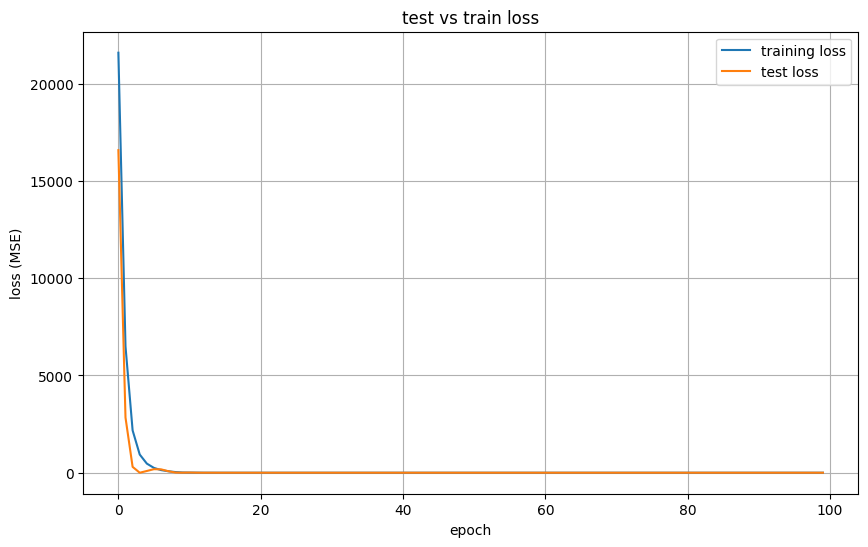

In [8]:
# 训练函数
def train_loop(model, train_loader, optimizer, loss_fn, device, epoch):
    model.train()
    total_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1} Training")
    
    for batch_idx, (data, target) in enumerate(pbar):
        # 将数据移至设备
        data, target = data.to(device), target.to(device)
        
        # 梯度清零
        optimizer.zero_grad()
        
        # 前向传播
        output = model(data)
        
        # 计算损失
        loss = loss_fn(output, target)
        
        # 反向传播
        loss.backward()
        
        # 更新参数
        optimizer.step()
        
        # 更新总损失
        total_loss += loss.item()
        
        # 更新进度条
        pbar.set_postfix({"loss": total_loss / (batch_idx + 1)})
    
    avg_loss = total_loss / len(train_loader)
    print(f"训练损失: {avg_loss:.6f}")
    return avg_loss

# 测试函数
def test_loop(model, test_loader, loss_fn, device):
    model.eval()
    test_loss = 0.0
    
    with torch.no_grad():
        for data, target in test_loader:
            # 将数据移至设备
            data, target = data.to(device), target.to(device)
            
            # 前向传播
            output = model(data)
            
            # 计算损失
            loss = loss_fn(output, target)
            
            # 更新总损失
            test_loss += loss.item()
    
    avg_loss = test_loss / len(test_loader)
    print(f"测试损失: {avg_loss:.6f}")
    return avg_loss

# 主函数
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 超参数
    input_dim = 4  # 输入特征数
    hidden_dim = 64
    n_head = 4
    learning_rate = 1e-3
    weight_decay = 1e-4
    num_epochs = 100
    
    # 创建模型
    model = RegressionModel(input_dim, hidden_dim, n_head).to(device)
    
    # 定义优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # 训练历史
    train_losses = []
    test_losses = []
    
    # 训练循环
    for epoch in range(num_epochs):
        train_loss = train_loop(model, train_loader, optimizer, loss_func, device, epoch)
        test_loss = test_loop(model, test_loader, loss_func, device)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        # 这里可以添加早停逻辑
    
    # 绘制训练和测试损失曲线
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='training loss')
    plt.plot(test_losses, label='test loss')
    plt.xlabel('epoch')
    plt.ylabel('loss (MSE)')
    plt.title('test vs train loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss_plot.png')
    
    # 保存模型
    torch.save(model.state_dict(), 'regression_model.pth')
    
    print("训练完成!")

if __name__ == "__main__":
    main()